# PREPARATIONS

In [1]:
##### LIBRARIES

import numpy as np
import pandas as pd

import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=26fe9d354971424174ac191f87f3e6bf216fdc3e007f4dd2885d854cec29e7b9
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch


In [ ]:
##### CUSTOM MODULES

sys.path.append('../codes')
from preprocessing import *
from data import EyeTrainData, EyeTestData
from utilities import seed_everything
from model import init_model

In [2]:
##### GPU CHECK

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [3]:
##### RANDOMNESS

seed = 23
seed_everything(seed)

# DATA PREPROCESSING

In [4]:
##### CHECK DIMENSIONS

# import data
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test  = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))

(3662, 2) (1928, 2)
---------------
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64


In [7]:
##### TRANSFORMATIONS

# parameters
batch_size = 25
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor(),
                                 ])

# valid transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])
                                 
# test transformations
test_trans = valid_trans

# DATA CHECK

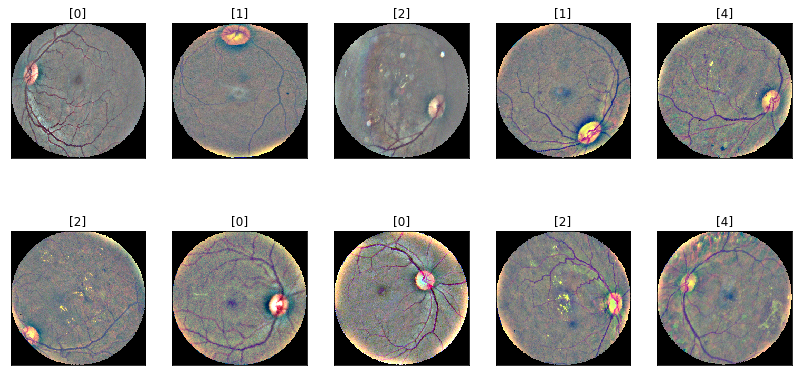

In [8]:
##### EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeTrainData(data       = train.iloc[0:10], 
                      directory  = '../input/aptos2019-blindness-detection/train_images',
                      transform  = train_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = True, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (14, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

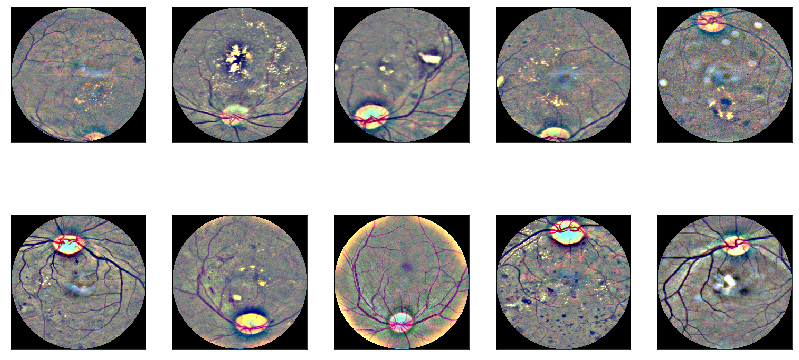

In [9]:
##### EXAMINE FIRST BATCH (TEST)

# get dataset
sample = EyeTestData(data       = test.iloc[0:10], 
                      directory  = '../input/aptos2019-blindness-detection/test_images',
                      transform  = test_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    
    # create plot
    fig = plt.figure(figsize = (14, 7))
    for i in range(10):
        ax = fig.add_subplot(2, 10/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))

    break

# MODEL SETUP

In [10]:
##### MODEL ARCHITECTURE

# model name
model_name = 'enet_b4'

# check architecture
model = init_model(model_name = model_name)
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv

# TRAINING

In [11]:
##### VALIDATION SETTINGS

# no. folds
num_folds = 4

# creating splits
skf    = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = seed)
splits = list(skf.split(train['id_code'], train['diagnosis']))

# placeholders
oof_preds = np.zeros((len(train), 1))

# timer
cv_start = time.time()

In [12]:
##### PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 15
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

In [13]:
##### CROSS-VALIDATION LOOP
for fold in tqdm(range(num_folds)):
    
    
    ### DATA PREPARATION

    # display information
    print('-' * 30)
    print('FOLD {}/{}'.format(fold + 1, num_folds))
    print('-' * 30)

    # load splits
    data_train = train.iloc[splits[fold][0]].reset_index(drop = True)
    data_valid = train.iloc[splits[fold][1]].reset_index(drop = True)

    # create datasets
    train_dataset = EyeTrainData(data      = data_train, 
                                 directory = '../input/aptos2019-blindness-detection/train_images',
                                 transform = train_trans)
    valid_dataset = EyeTrainData(data      = data_valid, 
                                 directory = '../input/aptos2019-blindness-detection/train_images',
                                 transform = valid_trans)

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size  = batch_size, 
                                               shuffle     = True, 
                                               num_workers = 4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                               batch_size  = batch_size, 
                                               shuffle     = False, 
                                               num_workers = 4)
    
    
    ### MODEL PREPARATION
    
    # placeholders
    val_kappas = []
    val_losses = []
    trn_losses = []
    bad_epochs = 0
    
    # load best OOF predictions
    if fold > 0:
        oof_preds = oof_preds_best.copy()
    
    # initialize and send to GPU
    model = init_model(train = True)
    model = model.to(device)

    # optimizer
    optimizer = optim.Adam(model._fc.parameters(), lr = eta)
    scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)
    
    
    ### TRAINING AND VALIDATION LOOP
    for epoch in range(max_epochs):

        ## PREPARATION

        # timer
        epoch_start = time.time()

        # reset losses
        trn_loss = 0.0
        val_loss = 0.0

        # placeholders
        fold_preds = np.zeros((len(data_valid), 1))


        ## TRAINING

        # switch regime
        model.train()
        
        # loop through batches
        for batch_i, data in enumerate(train_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)
            optimizer.zero_grad()

            # forward and backward pass
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss  = criterion(preds, labels)
                loss.backward()
                optimizer.step()

            # compute loss
            trn_loss += loss.item() * inputs.size(0)


        ## INFERENCE
        
        # initialize
        model.eval()

        # loop through batches
        for batch_i, data in enumerate(valid_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)

            # compute predictions
            with torch.set_grad_enabled(False):
                preds = model(inputs).detach()
                _, class_preds = preds.topk(1)
                fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = class_preds.cpu().numpy()

            # compute loss
            loss      = criterion(preds, labels)
            val_loss += loss.item() * inputs.size(0)

        # save predictions
        oof_preds[splits[fold][1]] = fold_preds
        
        # scheduler step
        scheduler.step()


        ### EVALUATION

        # evaluate performance
        fold_preds_round = fold_preds
        val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')
        
        # save perfoirmance values
        val_kappas.append(val_kappa)
        val_losses.append(val_loss / len(data_valid))
        trn_losses.append(trn_loss / len(data_train))

        
        ### EARLY STOPPING
        
        # display info
        print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
            epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
            trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
            (time.time() - epoch_start) / 60))
        
        # check if there is any improvement
        if epoch > 0:       
            if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
                bad_epochs += 1
            else:
                bad_epochs = 0

        # save model weights if improvement
        if bad_epochs == 0:
            oof_preds_best = oof_preds.copy()
            torch.save(model.state_dict(), '../models/model_{}_fold{}.bin'.format(model_name, fold + 1))

        # break if early stop
        if bad_epochs == early_stop:
            print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break

        # break if max epochs
        if epoch == (max_epochs - 1):
            print('Did not meet early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break
        

# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

------------------------------
FOLD 1/4
------------------------------
Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.6279 | val_loss = 0.5368 | val_kappa = 0.8725 | 7.30 min
- epoch 2/15 | lr = 0.001 | trn_loss = 0.5699 | val_loss = 0.5402 | val_kappa = 0.8662 | 7.25 min
- epoch 3/15 | lr = 0.001 | trn_loss = 0.5572 | val_loss = 0.5380 | val_kappa = 0.8631 | 7.31 min
- epoch 4/15 | lr = 0.001 | trn_loss = 0.5482 | val_loss = 0.5357 | val_kappa = 0.8590 | 7.29 min
- epoch 5/15 | lr = 0.00025 | trn_loss = 0.5658 | val_loss = 0.5357 | val_kappa = 0.8613 | 7.25 min
- epoch 6/15 | lr = 0.0005 | trn_loss = 0.5537 | val_loss = 0.5346 | val_kappa = 0.8604 | 7.28 min
Early stopping. Best results: loss = 0.5346, kappa = 0.8604 (epoch 6)

------------------------------
FOLD 2/4
------------------------------
Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.6535 | val_loss = 0.5295 | val_kappa = 0.8767 | 7.24 min
- epoc

# EVALUATION

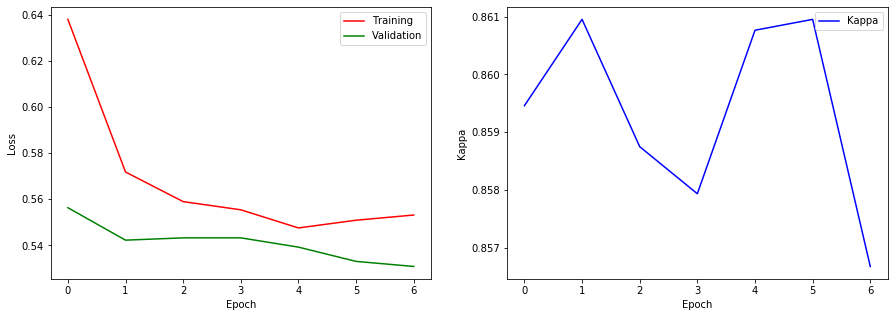

In [14]:
##### PLOT LOSS AND KAPPA DYNAMICS

# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

# export plot
plt.savefig('../figures/fig_loss_fine_tuning.pdf')

In [15]:
##### RECHECK PERFORMANCE

# evaluate performance
oof_preds_round = oof_preds.copy()
oof_kappa = metrics.cohen_kappa_score(train['diagnosis'], oof_preds_round.astype('int'), weights = 'quadratic')
print('OOF kappa = {:.4f}'.format(oof_kappa))

OOF kappa = 0.8760


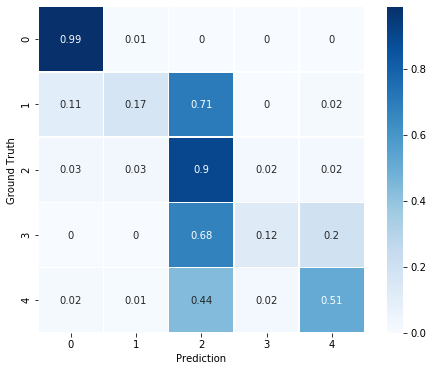

In [16]:
##### CONFUSION MATRIX

# construct confusion matrx
cm = confusion_matrix(train['diagnosis'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')
plt.savefig('../figures/fig_cm_fine_tuning.pdf')